## Import Libraries

In [30]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

In [31]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataset_classes = image_datasets['train'].classes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize Images

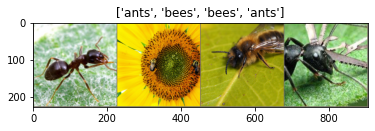

In [32]:
%matplotlib inline
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
plt.show()

In [26]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
def get_batches(dataloader, num_of_batches=3):
    assert(num_of_batches > 0)
    images, classes = next(iter(dataloader))
    for _ in range(num_of_batches - 1):
        image_batch, cls_batch = next(iter(dataloader))
        images = torch.cat([images, image_batch], dim=0)
        classes = torch.cat([classes, cls_batch], dim=0)
    return images, classes

def show_batches(images, classes):
    cols = (images.shape[0] + 3) // 4
    images = images.numpy().transpose(0,2,3,1)
    images = images * IMAGENET_STD + IMAGENET_MEAN
    fig, axes = plt.subplots(cols, 4, figsize=(12, cols * 3))
    for ax, img, img_cls in zip(axes.flatten(), images, classes.numpy()):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_xlabel(dataset_classes[img_cls], fontsize=20)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

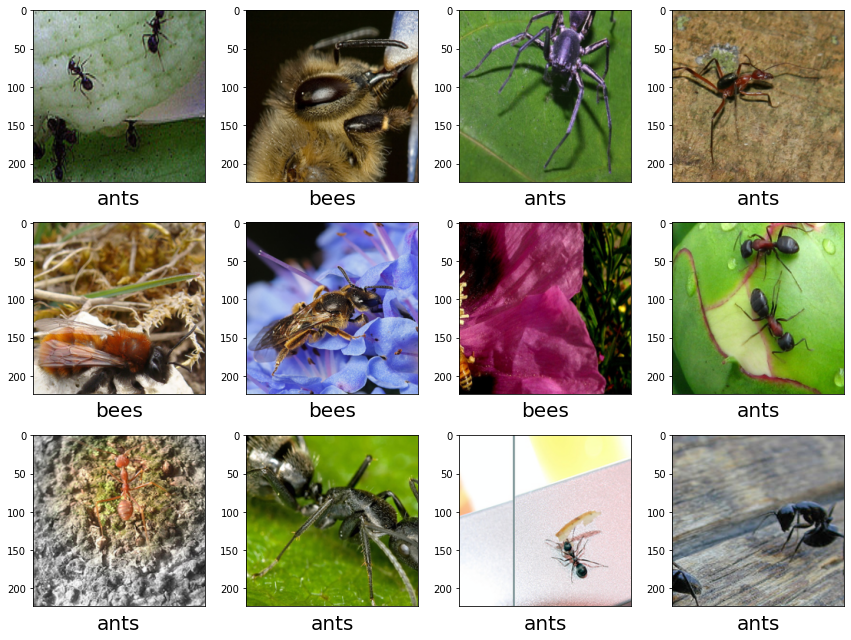

In [29]:
# show 12 images
images, classes = get_batches(dataloaders['train'])
show_batches(images, classes)

## Obtain CNN Codes and train last layer

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False # This is the KEY to FREEZE the early layers

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2) # New layer - a.k.a Logistic Regression Model on CNN codes!

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/Users/karthikmohan/Library/Python/3.8/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/karthikmohan/Library/Python/3.8/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/karthikmohan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() #Back propagation
                        optimizer.step() # Gradient Descent -> Heart of Training / Learning from data

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Train Last Layer 
This is equivalent to using CNN codes + Training a logistic regression model for multi-class classification
Note: Here we are learning the Logistic Regression Model as fine-tune on last layer + freeze all other layers
The LR model can also be trained outside of pytorch (e.g. sci-kit learn)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/24
----------
train Loss: 0.5834 Acc: 0.6680
val Loss: 0.3357 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4447 Acc: 0.7828
val Loss: 0.2721 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5122 Acc: 0.7951
val Loss: 0.2849 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5133 Acc: 0.7910
val Loss: 0.8479 Acc: 0.6405

Epoch 4/24
----------
train Loss: 0.5608 Acc: 0.7951
val Loss: 0.1946 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4324 Acc: 0.7992
val Loss: 0.4099 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.6031 Acc: 0.7377
val Loss: 0.2253 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3698 Acc: 0.8484
val Loss: 0.2159 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3523 Acc: 0.8525
val Loss: 0.2028 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3256 Acc: 0.8607
val Loss: 0.2022 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3502 Acc: 0.8238
val Loss: 0.2200 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2419 Acc: 0.9303
val Loss: 0.2026 Acc: 0.9346

Ep

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Visualize Model

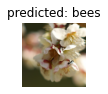

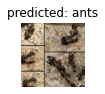

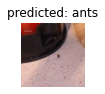

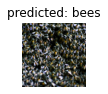

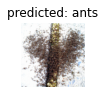

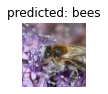

In [21]:
%matplotlib inline
visualize_model(model_conv)

plt.ioff()
plt.show()
